## Preprocessing Stage

**Serially correlated.** Best for situations where outcomes of previous days can be used to help determine the outcome of the next day

https://towardsdatascience.com/time-series-in-python-part-2-dealing-with-seasonal-data-397a65b74051

https://medium.com/@stallonejacob/time-series-forecast-a-basic-introduction-using-python-414fcb963000

EXAMPLE - armed robberies 
https://machinelearningmastery.com/time-series-forecast-case-study-python-monthly-armed-robberies-boston/

https://towardsdatascience.com/time-series-forecasting-with-prophet-54f2ac5e722e

In [177]:
import pandas as pd
from matplotlib import pyplot as plt
import re

from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import numpy as np
import fbprophet
from fbprophet import Prophet
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from pylab import rcParams

import logging

In [178]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=12).mean()
    #pd.rolling_mean(timeseries, window=12)
    rolstd =  pd.Series(timeseries).rolling(window=12).std()
#Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    # dftest = adfuller(timeseries, autolag='AIC')
    dftest = adfuller(timeseries)
    
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)


In [179]:
LME_futures = pd.read_excel('forecasting_raw_data/LME Futures Price.xlsx')
LME_futures = LME_futures.iloc[3:, 1:]
#LME_futures['Unnamed: 1'] = pd.datetime(LME_futures['Unnamed: 1'])
LME_futures.index = LME_futures['Unnamed: 1']



LME_futures = LME_futures.iloc[:, 1:]
LME_futures = LME_futures[LME_futures.index.year>=2009]
LME_futures.isnull().sum()
LME = LME_futures.iloc[:, 0]

#### Take Out Trend

In [180]:
LME = LME.resample('B').sum()

LME

LME_log = np.log(LME)

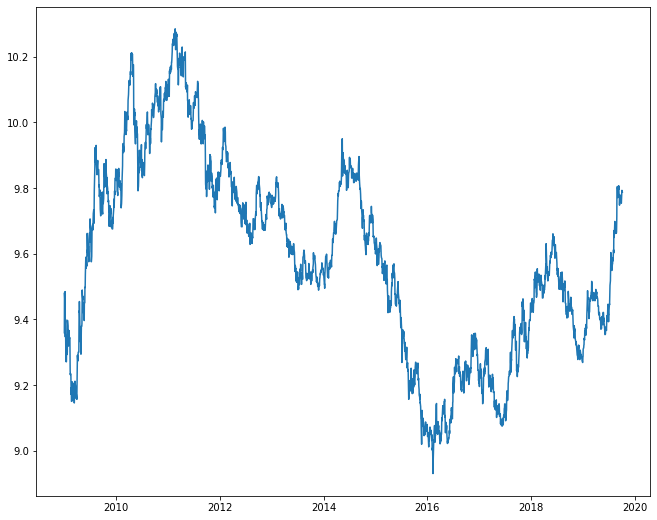

In [181]:
plt.plot(LME_log)
plt.show()

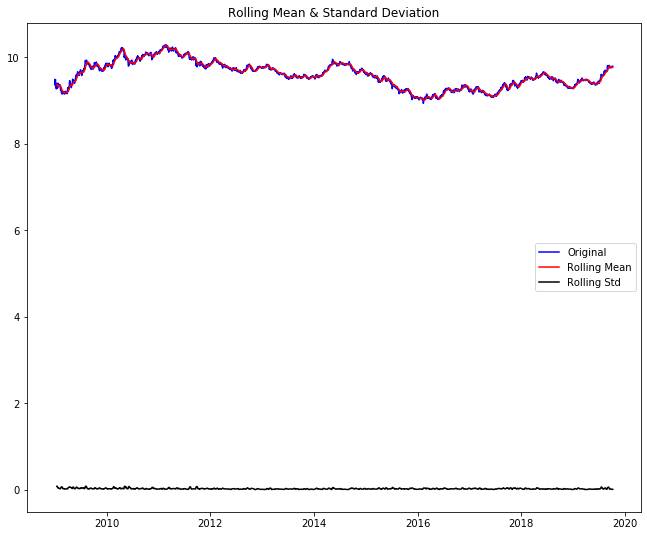

Results of Dickey-Fuller Test:
Test Statistic                   -1.795232
p-value                           0.382832
#Lags Used                        0.000000
Number of Observations Used    2807.000000
Critical Value (1%)              -3.432682
Critical Value (5%)              -2.862570
Critical Value (10%)             -2.567318
dtype: float64


In [182]:
test_stationarity(LME_log)

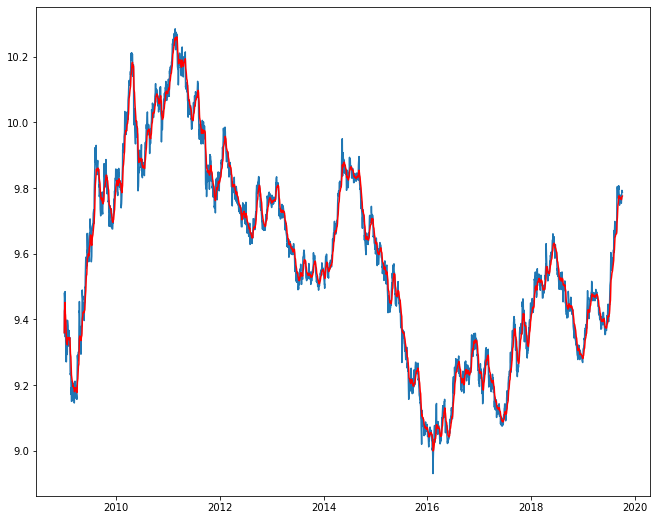

In [183]:
exponential_weight = LME_log.ewm(span=12).mean()
plt.plot(LME_log)

plt.plot(exponential_weight, color='red')

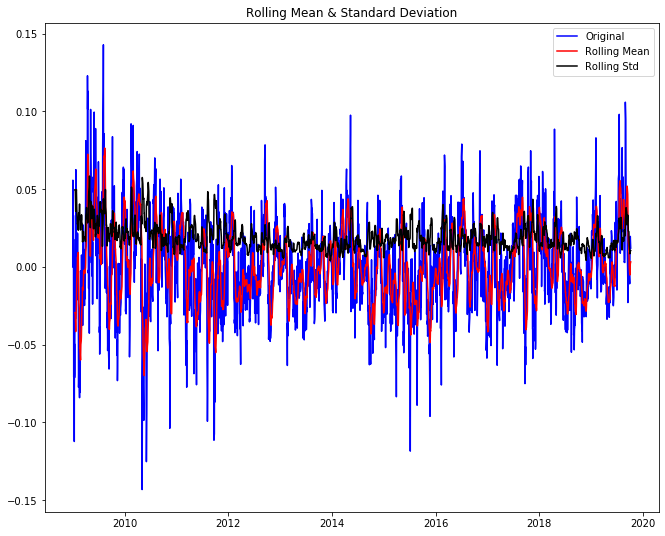

Results of Dickey-Fuller Test:
Test Statistic                -1.621079e+01
p-value                        3.988426e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.807000e+03
Critical Value (1%)           -3.432682e+00
Critical Value (5%)           -2.862570e+00
Critical Value (10%)          -2.567318e+00
dtype: float64


In [184]:
exponential_diff = LME_log-exponential_weight
exponential_diff.dropna()
test_stationarity(exponential_diff)

In [185]:
exdiff = exponential_diff
exdiff

Unnamed: 1
2009-01-01    0.000000
2009-01-02    0.055731
2009-01-05    0.017098
2009-01-06    0.033097
2009-01-07   -0.030119
2009-01-08   -0.070838
2009-01-09   -0.013335
2009-01-12   -0.112283
2009-01-13   -0.049478
2009-01-14   -0.071268
2009-01-15   -0.068846
2009-01-16   -0.044241
2009-01-19   -0.002418
2009-01-20    0.017686
2009-01-21   -0.033430
2009-01-22   -0.020867
2009-01-23    0.062509
2009-01-26    0.038159
2009-01-27   -0.004295
2009-01-28    0.021987
2009-01-29   -0.007273
2009-01-30   -0.021249
2009-02-02   -0.010606
2009-02-03    0.012969
2009-02-04    0.021550
2009-02-05   -0.003762
2009-02-06    0.000966
2009-02-09    0.000225
2009-02-10   -0.053503
2009-02-11   -0.077406
                ...   
2019-08-27    0.005350
2019-08-28    0.025867
2019-08-29    0.040863
2019-08-30    0.105881
2019-09-02    0.094932
2019-09-03    0.075879
2019-09-04    0.063829
2019-09-05    0.030193
2019-09-06    0.036491
2019-09-09    0.047827
2019-09-10    0.041683
2019-09-11    0.027015


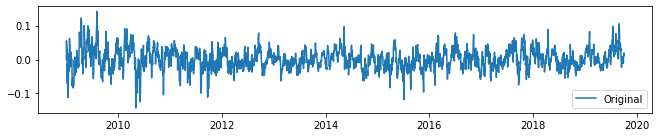

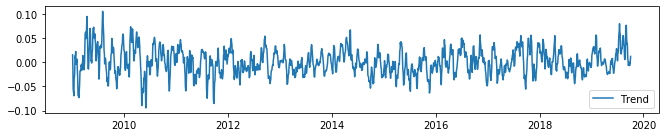

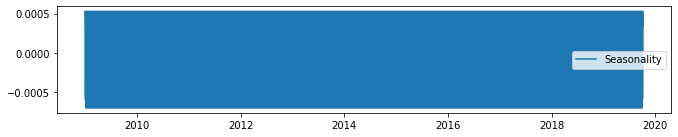

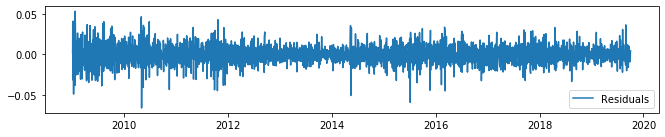

In [186]:
rcParams['figure.figsize'] = 11, 9
decomposition = sm.tsa.seasonal_decompose(exdiff)
#fig = decomposition.plot()
#plt.show()

trend = decomposition.trend
seasonality = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(exdiff, label='Original')
plt.legend(loc='best')
plt.show()

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.show()

plt.subplot(413)
plt.plot(seasonality, label='Seasonality')
plt.legend(loc='best')
plt.show()

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.show()

In [187]:
exdiff.to_csv('exdiff_preprocessed.csv', index=True, header=True)

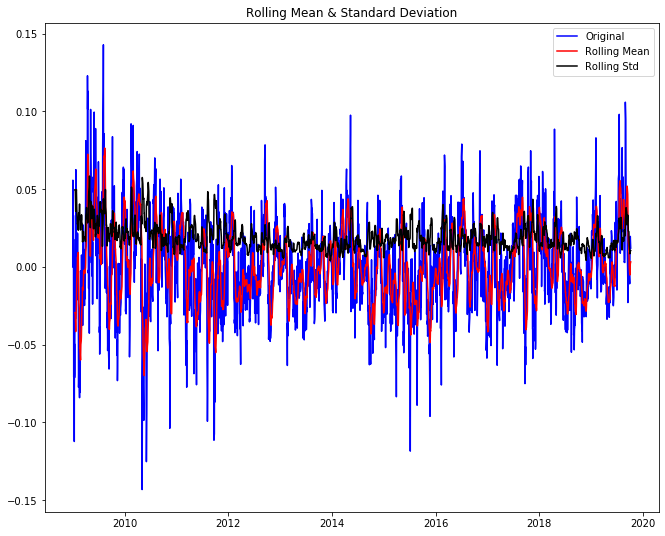

Results of Dickey-Fuller Test:
Test Statistic                -1.621079e+01
p-value                        3.988426e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.807000e+03
Critical Value (1%)           -3.432682e+00
Critical Value (5%)           -2.862570e+00
Critical Value (10%)          -2.567318e+00
dtype: float64


In [66]:
df = pd.read_csv('exdiff_preprocessed.csv')
df.index = df['Unnamed: 1']
df = df.iloc[:, 1:]
df.head()

df = df['Cash Price ($/MT)'].squeeze()
df.index = pd.to_datetime(df.index)
test_stationarity(df)

# Modeling

https://towardsdatascience.com/time-series-forecasting-with-prophet-54f2ac5e722e

In [188]:
logging.getLogger().setLevel(logging.ERROR)

In [85]:
list_one = list(exdiff.index)
list_two = list(exdiff)
df = pd.DataFrame(list(zip(list_one, list_two)), columns = ['ds', 'y'])


In [189]:
prediction_size = 365
train_df = df[:-prediction_size]

In [190]:
print('CURRENT')
print(train_df.head())
print(train_df.tail())
print()
print('FUTURE')
print(future.head())
print(future.tail())

CURRENT
          ds         y
0 2009-01-01  0.000000
1 2009-01-02  0.055731
2 2009-01-05  0.017098
3 2009-01-06  0.033097
4 2009-01-07 -0.030119
             ds         y
2438 2018-05-08 -0.006548
2439 2018-05-09 -0.003279
2440 2018-05-10 -0.005434
2441 2018-05-11  0.006080
2442 2018-05-14  0.031104

FUTURE
          ds
0 2009-01-01
1 2009-01-02
2 2009-01-05
3 2009-01-06
4 2009-01-07
             ds
2803 2019-05-10
2804 2019-05-11
2805 2019-05-12
2806 2019-05-13
2807 2019-05-14


In [240]:
test_df = df[-prediction_size:]

In [241]:
m = Prophet()
m.fit(train_df)

future = m.make_future_dataframe(periods = prediction_size)
forecast = m.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2009-01-01,0.007252,-0.031163,0.045874,0.007252,0.007252,-0.000571,-0.000571,-0.000571,0.000831,0.000831,0.000831,-0.001402,-0.001402,-0.001402,0.0,0.0,0.0,0.006680
1,2009-01-02,0.007242,-0.033598,0.046754,0.007242,0.007242,-0.000078,-0.000078,-0.000078,0.001823,0.001823,0.001823,-0.001901,-0.001901,-0.001901,0.0,0.0,0.0,0.007165
2,2009-01-05,0.007213,-0.033362,0.042727,0.007213,0.007213,-0.000678,-0.000678,-0.000678,0.002072,0.002072,0.002072,-0.002750,-0.002750,-0.002750,0.0,0.0,0.0,0.006536
3,2009-01-06,0.007203,-0.032948,0.041891,0.007203,0.007203,-0.002045,-0.002045,-0.002045,0.000748,0.000748,0.000748,-0.002794,-0.002794,-0.002794,0.0,0.0,0.0,0.005158
4,2009-01-07,0.007194,-0.032365,0.044023,0.007194,0.007194,-0.000931,-0.000931,-0.000931,0.001782,0.001782,0.001782,-0.002713,-0.002713,-0.002713,0.0,0.0,0.0,0.006262


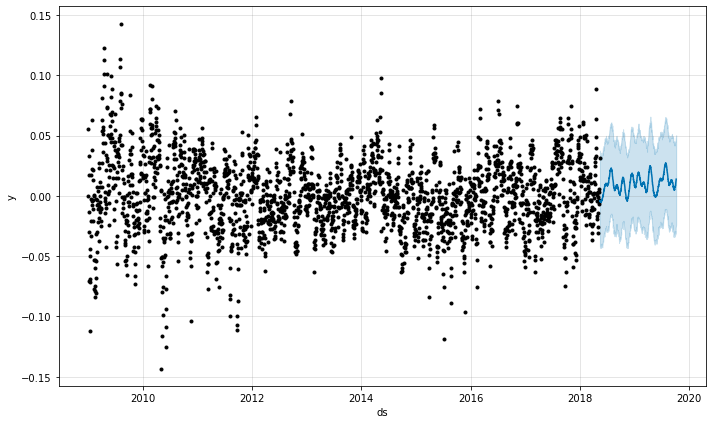

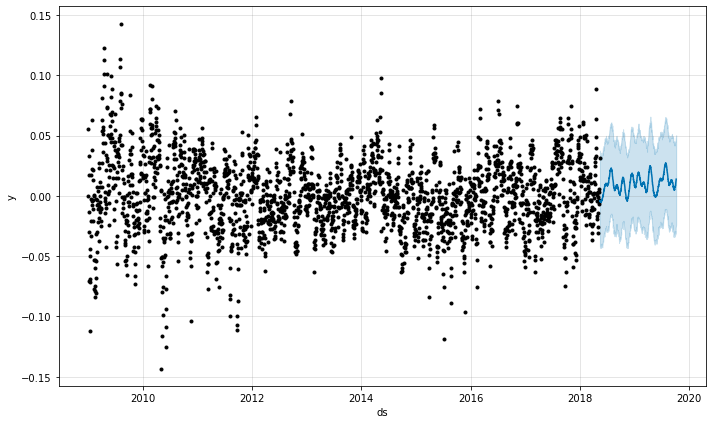

In [246]:
forecast = m.predict(test_df)
m.plot(forecast)

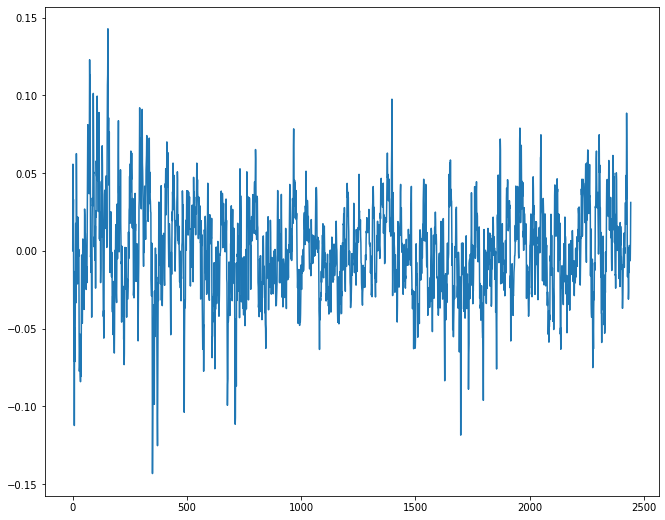

In [174]:
plt.plot(train_df['y'])

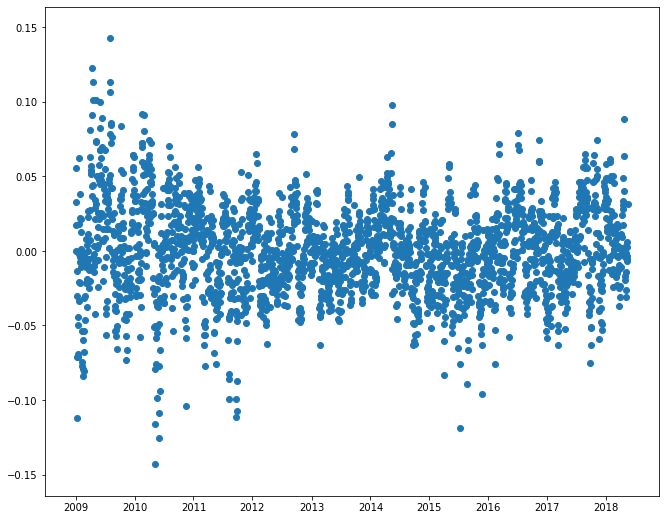

In [176]:
plt.scatter(train_df['ds'], train_df['y'])

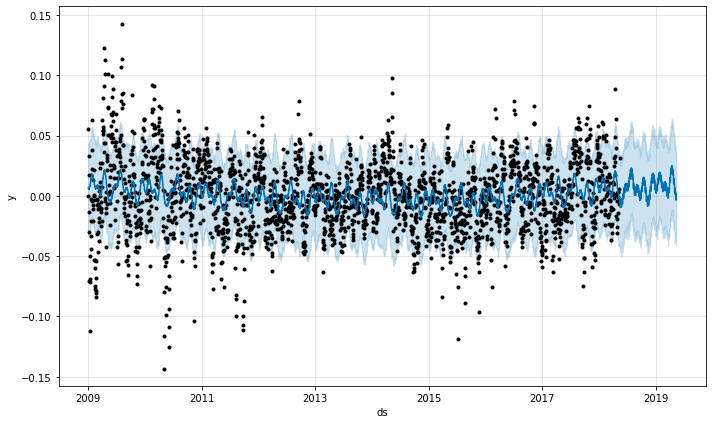

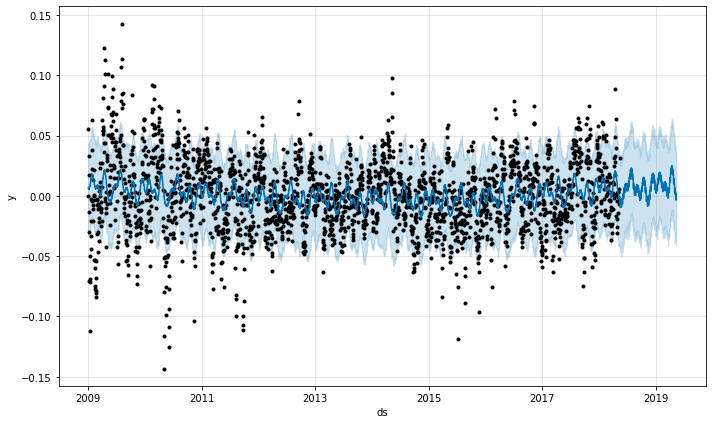

In [88]:
m.plot(forecast)

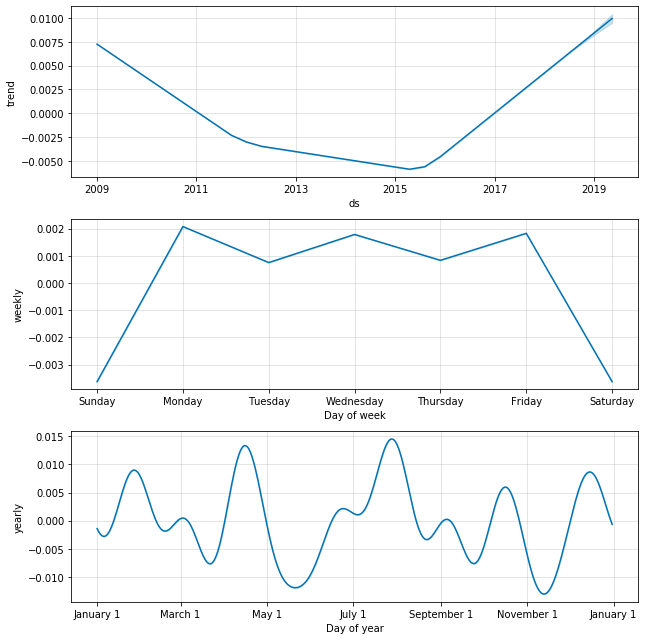

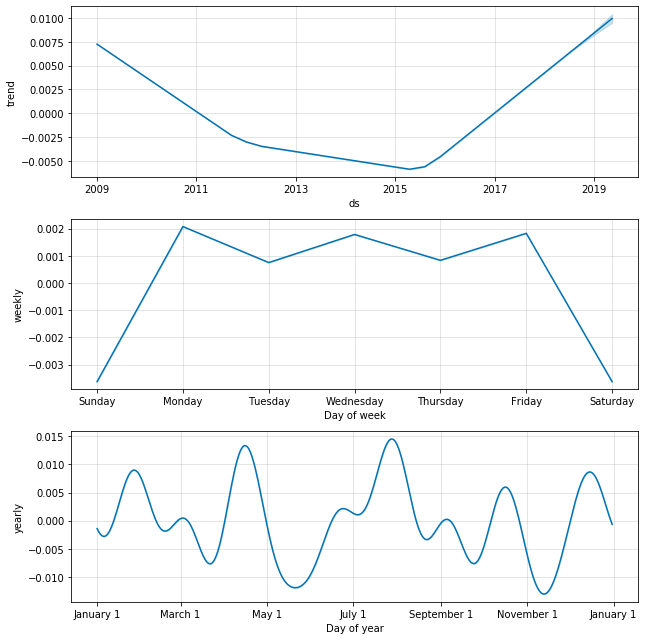

In [89]:
m.plot_components(forecast)

In [252]:
'''Joins predicted values with actual values'''
def make_comparison_dataframe(historical, forecast):
    
    return forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(historical.set_index('ds'))

# Creating comparison dataframe
cmp_df = make_comparison_dataframe(df, forecast)



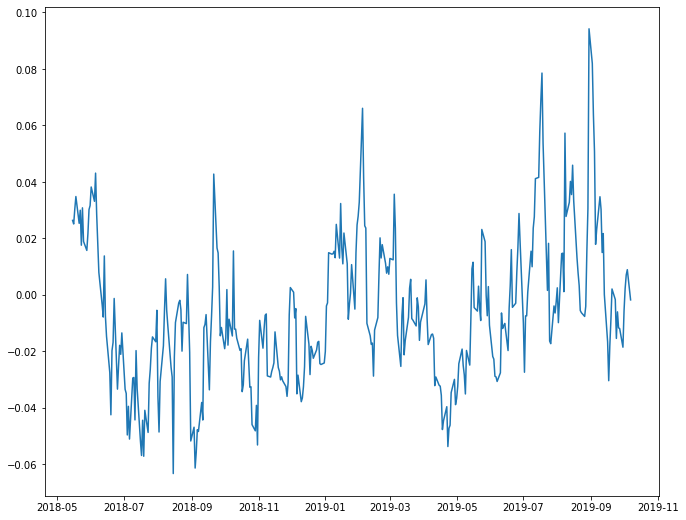

In [250]:
cmp_df['error'] =  cmp_df['y'] - cmp_df['yhat']
cmp_df.head()
plt.plot(cmp_df['error'])

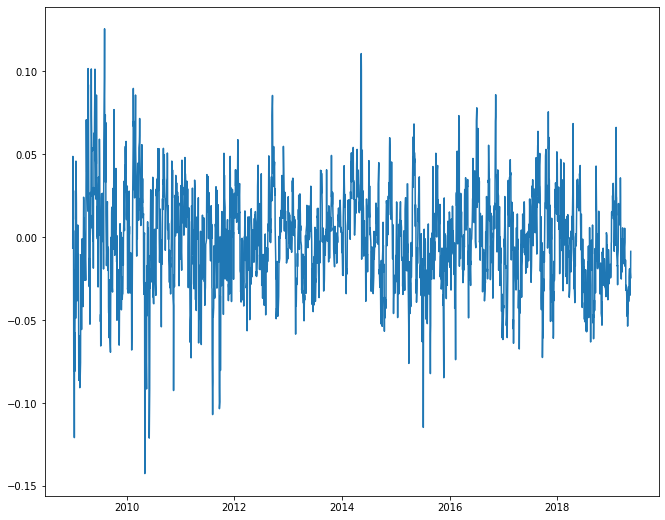

In [151]:
plt.plot(cmp_df['error'])

In [251]:
cmp_df = cmp_df.dropna()

def calculate_forecast_errors(df, prediction_size):
    df = df.copy()
    df['error'] = df['y'] - df['yhat']
    df['percentage'] = 100*df['error']/df['y']
    
    
    predicted_part = df[-prediction_size:]
    error_mean = lambda error_name: np.mean(np.abs(predicted_part[error_name]))
    print(predicted_part.head())
    return {'MAPE': error_mean('percentage'), 'MAE': error_mean('error')}

for err_name, err_value in calculate_forecast_errors(cmp_df.dropna(), prediction_size).items():
    print(err_name, err_value)

                yhat  yhat_lower  yhat_upper         y     error  percentage
ds                                                                          
2018-05-15 -0.004569   -0.042023    0.037405  0.021792  0.026360  120.965223
2018-05-16 -0.003777   -0.041395    0.033005  0.021323  0.025099  117.712625
2018-05-17 -0.004918   -0.042019    0.033591  0.025412  0.030330  119.351557
2018-05-18 -0.004069   -0.043186    0.033646  0.030741  0.034810  113.235573
2018-05-21 -0.003999   -0.039670    0.034179  0.021333  0.025331  118.743514
MAPE 371.7307274082513
MAE 0.021514164935875952


In [274]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))*100

def root_mean_squared_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.sqrt(((y_pred - y_true) **2).mean())
    #return np.mean(np.abs((y_true - y_pred) / y_true))*100


In [273]:
np.sqrt(9)

3.0

In [277]:
print('mape', mean_absolute_percentage_error(cmp_df['y'], cmp_df['yhat']))

print('rmse', root_mean_squared_error(cmp_df['y'], cmp_df['yhat']))

mape 371.7307274082514
rmse 0.026597603528845024


In [267]:


cmp_df.head()

,yhat,yhat_lower,yhat_upper,y
ds,,,,
2018-05-15,-0.004569,-0.042023,0.037405,0.021792
2018-05-16,-0.003777,-0.041395,0.033005,0.021323
2018-05-17,-0.004918,-0.042019,0.033591,0.025412
2018-05-18,-0.004069,-0.043186,0.033646,0.030741
2018-05-21,-0.003999,-0.039670,0.034179,0.021333
